### Kaggle Import


In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

> A type of image-based sequence recognition problem is an optical character recognition problem. And, for a sequence recognition problem, recurrent neural networks (RNN) are best suited, whereas convolution neural networks (CNN) are best suited for an image-based problem (CNN). To deal with OCR issues, we need to combine both of these CNN and RNN.

**We can break the implementation of CRNN network into following steps:**

1. Import Data

2. Data Preprocessing

3. Model Building

4. Defining Loss Function

5. Training Model

6. Decoding Outputs from Prediction

# Import Libraries

In [ ]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences
from google.colab.patches import cv2_imshow

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K

#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from PIL import Image

import tensorflow as tf

#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


# Intialize the variable

In [ ]:
images = []
labels = []

RECORDS_COUNT = 25000

In [ ]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images=[]
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

# Import Data

1. **Personlized Data**

In [ ]:
engl=pd.read_csv('/content/english.csv')
engl.head()

,image,label
0,Img/img001-001.png,0
1,Img/img001-002.png,0
2,Img/img001-003.png,0
3,Img/img001-004.png,0
4,Img/img001-005.png,0


2. **IAM Dataset**

In [ ]:

with open('/content/IAM/words.txt') as f:
    contents = f.readlines()[18:22539]

lines = [line.strip() for line in contents]
lines[-1]

'b06-110-07-03 ok 173 987 2031 8 6 . .'

# Data-Preprocessing

**1. Image Pre-processing**

In [ ]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape

#     _, img = cv2.threshold(img,
#                            128,
#                            255,
#                            cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape

    img = img.astype('float32')

    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape

    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape

    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)

    img = cv2.subtract(255, img)

    img = np.expand_dims(img, axis=2)

    # Normalize
    img = img / 255

    return img

**2. Label-Encoding**

In [ ]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

# string.ascii_letters + string.digits (Chars & Digits)
# or
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        print(index)
        print(chara)
        dig_lst.append(char_list.index(chara))

    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [ ]:
encode_to_labels("ABDULLAH")

0
A
1
B
2
D
3
U
4
L
5
L
6
A
7
H


[26, 27, 29, 46, 37, 37, 26, 33]

# Personalized Data

In [ ]:
filepath=""
for i in range(len(engl)):

        splits_id=engl["image"][i].split('/')
        filepath = engl["image"][i]
                #'/content/Img/{}/{}'.format(splits_id[0],
         #                                         splits_id[1])

        # process image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue

        # process label
        try:
            word=engl['label'][i]
            label = encode_to_labels(word)
        except:
            continue

        if i % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)

        if len(word) > max_label_len:
            max_label_len = len(word)


        if i >= RECORDS_COUNT:
            break

Streaming output truncated to the last 5000 lines.
0
G
0
G
0
G
0
G
0
G
0
G
0
G
0
G
0
G
0
G
0
G
0
G
0
G
0
G
0
G
0
G
0
G
0
G
0
G
0
G
0
G
0
G
0
G
0
G
0
G
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
H
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
I
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
J
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0
K
0

# IAM-Dataset

In [ ]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]

    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])

        splits_id = word_id.split('-')
        filepath = './IAM/words/{}/{}-{}/{}.png'.format(splits_id[0],
                                                  splits_id[0],
                                                  splits_id[1],
                                                  word_id)

        # process image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue

        # process label
        try:
            label = encode_to_labels(word)
        except:
            continue

        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)

        if len(word) > max_label_len:
            max_label_len = len(word)

    if index >= RECORDS_COUNT:
        break

In [ ]:
train_labels[22]
#train_labels[]1

[13]

In [ ]:
train_padded_label = pad_sequences(train_labels,
                             maxlen=max_label_len,
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels,
                             maxlen=max_label_len,
                             padding='post',
                             value=len(char_list))

In [ ]:
train_labels[3101]

[38, 40, 47, 30]


> pad each output label to maximum text length

In [ ]:
train_padded_label[3101]

array([38, 40, 47, 30, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78],
      dtype=int32)

In [ ]:
train_padded_label.shape, valid_padded_label.shape

((21143, 17), (2348, 17))

In [ ]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

# Model Building

**Model Description**
1. Input shape for our architecture having an input image of height 32 and width 128.
2. Here we used seven convolution layers of which 6 are having kernel size (3,3) and the last one is of size (2.2). And the number of filters is increased from 64 to 512 layer by layer.
3. Two max-pooling layers are added with size (2,2) and then two max-pooling layers of size (2,1) are added to extract features with a larger width to predict long texts.
4. Also, we used batch normalization layers after fifth and sixth convolution layers which accelerates the training process.
5. Then we used a lambda function to squeeze the output from conv layer and make it compatible with LSTM layer.
6. Then used two Bidirectional LSTM layers each of which has 128 units. This RNN layer gives the output of size (batch_size, 31, 79). Where 79 is the total number of output classes including blank character.

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as tf_keras_backend
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

tf_keras_backend.set_image_data_format('channels_last')
tf_keras_backend.image_data_format()

'channels_last'

In [ ]:
def Model1():
    # input with shape of height=32 and width=128
    inputs = Input(shape=(32,128,3))

    # convolution layer with kernel size (3,3)
    conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
    # poolig layer with kernel size (2,2)
    pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

    conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

    conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

    conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
    # poolig layer with kernel size (2,1)
    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

    conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)

    conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

    conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
    blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

    outputs = Dense(78+1, activation = 'softmax')(blstm_2)

    # model to be used at test time
    act_model = Model(inputs, outputs)

    return act_model,outputs,inputs

In [ ]:
act_model,outputs,inputs=Model1()

In [ ]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 128, 3)]      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 128, 64)       1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 32, 256)        295168

In [ ]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

# Training Model

In [ ]:
batch_size = 5
epochs = 20
e = str(epochs)
optimizer_name = 'sgd'

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="{}o-{}r-{}e-{}t-{}v.hdf5".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=1,
                    callbacks=callbacks_list)


In [ ]:
model.save(filepath='./model3.h5', overwrite=False, include_optimizer=True)

# Performance check

For computing the performance, I will be using the **Jaro-Winkler** algorithm to detect similarity between the captured text and the actual text.

In [ ]:
!pip install python-Levenshtein==0.12.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 3.3 MB/s 
Reason for being yanked: Insecure, upgrade to 0.12.1
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp37-cp37m-linux_x86_64.whl size=145904 sha256=e5342c29d50cc79f8db9775530c67173767fd6b514f05d30e6d0d1960de08cbe
  Stored in directory: /root/.cache/pip/wheels/f0/9b/13/49c281164c37be18343230d3cd0fca29efb23a493351db0009
Successfully built python-Levenshtein


In [ ]:

filepath='./sgdo-25000r-20e-21143t-2348v.hdf5'
# load the saved best model weights
act_model.load_weights(filepath)

# predict outputs on validation images
prediction = act_model.predict(valid_images)

# use CTC decoder
decoded = K.ctc_decode(prediction,
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)

import Levenshtein as lv

total_jaro = 0

# see the results
for i, x in enumerate(out):
    letters=''
    for p in x:
        if int(p) != -1:
            letters+=char_list[int(p)]
    total_jaro+=lv.jaro(letters, valid_original_text[i])

print('jaro :', total_jaro/len(out))


NameError: ignored

In [ ]:
# predict outputs on validation images
i=1500
j=1600
prediction = act_model.predict(valid_images[i:j])

# use CTC decoder
decoded = K.ctc_decode(prediction,
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

# see the results
for _, x in enumerate(out):

    print("original_text =  ", valid_original_text[i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(valid_images[i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    i+=1
    print('\n')

# Visualization of Loss and Acurracy

In [ ]:
#plot accuracy and loss
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)


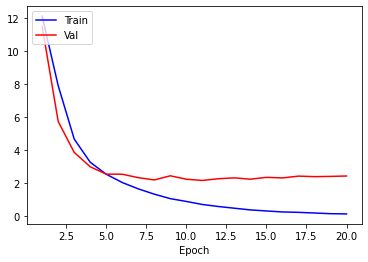

In [ ]:
plotgraph(epochs, loss, val_loss)

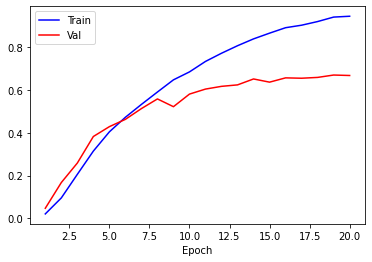

In [ ]:
plotgraph(epochs, acc, val_acc)

In [ ]:
# get best model index
minimum_val_loss = np.min(history.history['val_loss'])
best_model_index = np.where(history.history['val_loss'] == minimum_val_loss)[0][0]

best_loss = str(history.history['loss'][best_model_index])
best_acc = str(history.history['accuracy'][best_model_index])
best_val_loss = str(history.history['val_loss'][best_model_index])
best_val_acc = str(history.history['val_accuracy'][best_model_index])

In [ ]:
print(best_loss)
print(best_acc)
print(best_val_acc)

0.6917164921760559
0.733055830001831
0.6039182543754578


# Predicting My Own handwriting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install fpdf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40725 sha256=1f698f87873c9629d274bfd00bf0adb05211136e8ea93e41b8e3fd019717419e
  Stored in directory: /root/.cache/pip/wheels/d7/ca/c8/86467e7957bbbcbdf4cf4870fc7dc95e9a16404b2e3c3a98c3
Successfully built fpdf


In [ ]:
import keras
act_model=keras.models.load_model('/content/drive/MyDrive/FYP/LSTM/model3.h5',compile = False)
a=act_model.input[0]
b=act_model.get_layer('dense')
Model2=Model(inputs=a,outputs=b.output)

In [ ]:
Model2.input

<KerasTensor: shape=(None, 32, 128, 1) dtype=float32 (created by layer 'input_1')>

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(Model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
df=pd.DataFrame(columns=['Orignal','Predicted'])

In [ ]:
valid_images.shape

(2348, 32, 128, 1)

In [ ]:
valid_images[i:j].shape

(2348, 32, 128, 1)

In [ ]:
valid_images = np.asarray(valid_images)


In [ ]:
i=0
j=2348
prediction = Model2.predict(valid_images[i:j])

# use CTC decoder
decoded = K.ctc_decode(prediction,
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

# see the results


In [ ]:
i=0
j=2348
for _, x in enumerate(out):

    print("original_text =  ", valid_original_text[i])
    print("predicted text = ", end = '')
    lis=""
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
            lis=lis+char_list[int(p)]

    new_row = {'Orignal':valid_original_text[i], 'Predicted':lis}

    df = df.append(new_row, ignore_index=True)
 #   plt.imshow(valid_images[i], cmap=plt.cm.gray)
    #plt.show()
    i+=1
    print('\n')

In [ ]:
from google.colab import files

df.to_csv('output.csv', encoding = 'utf-8-sig')
files.download('output.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pip install fuzzywuzzy
from fuzzywuzzy import fuzz


In [ ]:
df['match']=None

In [ ]:
for lop in range(0,2348):
  df.loc[lop]['match'] = fuzz.ratio(df.loc[lop]['Orignal'], df.loc[lop]['Predicted'])

In [ ]:
df

,Orignal,Predicted,match
0,0,O,0
1,0,o,0
2,0,0,100
3,0,0,100
4,0,O,0
...,...,...,...
2343,in,in,100
2344,",",",",100
2345,.,.,100
2346,who,who,100


In [ ]:
img = cv2.imread('/content/a01-000u-00-05.png', cv2.IMREAD_GRAYSCALE)
img=process_image(img)
img=tf.expand_dims(img, axis=0)
prediction = Model2.predict(img)
decoded = K.ctc_decode(prediction,
                               input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                               greedy=True)[0][0]
out = K.get_value(decoded)

for i, x in enumerate(out):
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            s=char_list[int(p)]
            print(s)



predicted text = G
a
i
t
s
k
e
l
l


array([ 32, 128,   1])

In [ ]:
import tensorflow as tf



In [ ]:
img.shape

TensorShape([1, 32, 128, 1])

predicted text = M
O
V
E


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

plot_model(act_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import traceback

def predict(directory):
    dir=directory
    for filename in os.listdir(dir):
        test=[]
        filepath=os.path.join(dir, filename)
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

        try:
            test_img = process_image(img)
            test.append(test_img)
            test_img=np.asarray(test)
        except:
            print('hi')

        try:
            print(test_img.shape)
            prediction = act_model.predict(test_img)

            # use CTC decoder
            decoded = K.ctc_decode(prediction,
                               input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                               greedy=True)[0][0]
            out = K.get_value(decoded)

            for i, x in enumerate(out):
                print("predicted text = ", end = '')
                for p in x:
                    if int(p) != -1:
                        s=char_list[int(p)]
                        print(s)
            img = Image.open(filepath)
            name = './word1/' + str(s) + '.png'
            img.save(name, 'PNG')

            del test[-1]

        except:
            print(filename)
            traceback.print_exc()



predict('/content/img')

In [ ]:
test_img

[]

# Converting voice text to handwritten

In [ ]:
mkdir ./img2

In [ ]:
cp ../input/my-own/space.png  ./word1

In [ ]:
from PIL import Image

from fpdf import FPDF

img=Image.open("../input/my-own/bg.jpg")
sizeOfSheet=img.width
gap,_=0,0
allowedchar='ABCDEFGHIJKLMNOPQRSTUVWXYZqwertyuiopasdfghjklzxcvbnm(),.?;1234567890'

def Write(char):
    if char=='\n':
        pass
    else:
        global gap,_
        cases=Image.open("./word1/%s.png"%char)
        cases=cases.resize((50,100))
        img.paste(cases,(gap,_))
        size=cases.width
        gap+=size
        del cases

def Letters(word):
    global gap,_
    if gap > sizeOfSheet-95*(len(word)):
        gap=0
        _+=200
    for letter in word:
        if letter in allowedchar:
            Write(letter)


def Word(Input):
    wordlist=Input.split(' ')
    for i in wordlist:
        Letters(i)
        Write('space')




if __name__=='__main__':

    try:
        with open("../input/my-own/data.txt",'r') as file:
            data=file.read().replace('\n','')
            l=len(data)
            nn=len(data)//l
            print(nn)
            print(l)
            chunks,chunk_size=len(data),len(data)//nn+1
            p=[data[i:i+chunk_size] for i in range(0,chunks,chunk_size)]

            for i in range(0,len(p)):
                Word(p[i])
                Write('\n')
                img.save("./img2/%doutt.png"%i)
                img1=Image.open("../input/my-own/bg.jpg")
                img=img1
                gap,_=0,0
    except ValueError as E:
        print("{}\nTry again",format(E))
    imageList=[]
    for i in range(0,len(p)):
        imageList.append("./img2/%doutt.png"%i)

    cover=Image.open(imageList[0])
    width,height=cover.size
    pdf=FPDF(unit="pt",format=[width,height])
    for i in range(0,len(imageList)):
        pdf.add_page()
        pdf.image(imageList[i],0,0)
    pdf.output("./img2/word1.pdf","F")

1
17
